In [1]:
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
res = 24

In [3]:
# This is just a copy of the simple MNIST tutorial
# https://keras.io/examples/vision/mnist_convnet/
model_terrain = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(8, activation="softmax"),
    ]
)

model_crowns = keras.Sequential(
    [
        keras.Input(shape=(res, res, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
N = 225
noise_loops = 101

training_x= np.zeros((4*noise_loops*N, res, res, 3))
terrain_y = np.zeros(4*noise_loops*N)
crowns_y = np.zeros(4*noise_loops*N)

cnt = 0
for file in os.listdir("training/"):
    tile = cv2.cvtColor(cv2.imread("training/" + file), cv2.COLOR_BGR2RGB)
    tile = cv2.resize(tile, (res, res))
    label = file.split(".")[0].split("_")

    for k in range(4):
        training_x[cnt] = tile
        terrain_y[cnt] = int(label[2])
        crowns_y[cnt] = int(label[3])
        cnt = cnt + 1
        
        for j in range(noise_loops - 1):
            tmp = tile.copy()
            tmp = tmp + np.random.normal(0, 0.1, tmp.shape)
            training_x[cnt] = tmp
            terrain_y[cnt] = int(label[2])
            crowns_y[cnt] = int(label[3])
            cnt = cnt + 1

        tile = np.rot90(tile)


Text(0.5, 1.0, '1.0')

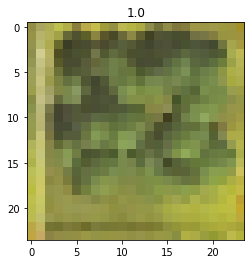

In [5]:
plt.imshow(training_x[12345].astype('uint8'))
plt.title(terrain_y[12345])

In [6]:
model_terrain.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model_crowns.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [7]:
print("Fit model on training data")
history = model_terrain.fit(
    training_x,
    terrain_y,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(training_x, terrain_y),
)

Fit model on training data
Epoch 1/5
1421/1421 [==============================] - 16s 11ms/step - loss: 0.4552 - sparse_categorical_accuracy: 0.9344 - val_loss: 4.6711e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0045 - val_sparse_categorical_accuracy: 0.9989
Epoch 3/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1421/1421 [==============================] - 16s 11ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
1421/1421 [==============================] - 16s 11ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000


In [8]:
score = model_terrain.evaluate(training_x, terrain_y, verbose=1)


2841/2841 [==============================] - 6s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000


array([[0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

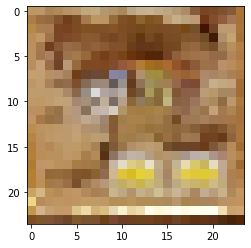

In [9]:
import matplotlib.pyplot as plt

plt.imshow(training_x[525].astype('uint8'))
model_terrain.predict(training_x[525:526])

In [10]:
model_terrain.save("models/terrain_model.keras")

In [11]:
print("Fit model on training data")
history = model_crowns.fit(
    training_x,
    crowns_y,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(training_x, crowns_y),
)

Fit model on training data
Epoch 1/5
1421/1421 [==============================] - 16s 11ms/step - loss: 0.4555 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.0616 - val_sparse_categorical_accuracy: 0.9811
Epoch 2/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.0574 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.1683e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1421/1421 [==============================] - 16s 11ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9941 - val_loss: 4.5572e-09 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
1421/1421 [==============================] - 15s 11ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9965 - val_loss: 2.7839e-08 - val_sparse_categorical_accuracy: 1.0000


array([[4.8204894e-16, 1.0710064e-13, 1.0000000e+00, 0.0000000e+00]],
      dtype=float32)

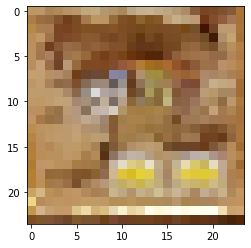

In [12]:
plt.imshow(training_x[525].astype('uint8'))
model_crowns.predict(training_x[525:526])

array([[1., 0., 0., 0.]], dtype=float32)

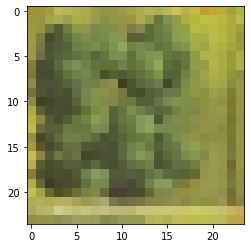

In [13]:
plt.imshow(training_x[12500].astype('uint8'))
model_crowns.predict(training_x[12500:12501])

In [14]:
model_crowns.save("models/crowns_model.keras")